In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('BORIVALI_DWLR_REALTIME_multi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [10]:
def create_features(df):
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    return df

df = create_features(df)

In [11]:
df_encoded = pd.get_dummies(df, columns=['status'], prefix='status', dtype=int)
status_cols = [col for col in df_encoded.columns if col.startswith('status_')]

# Define Targets and Features
numerical_targets = ['water_level_m', 'rainfall_mm', 'temperature_c', 'demand_mcm', 'availability']
all_targets = numerical_targets + status_cols
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

In [12]:
models = {}
metrics_summary = []

X = df_encoded[features]

print("--- Training XGBoost Models and Calculating NRMSE ---")
for target in all_targets:
    y = df_encoded[target]
    
    # Range for normalization
    target_range = y.max() - y.min()
    if target_range == 0: target_range = 1
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize XGBoost Regressor
    # objective='reg:squarederror' is used for numerical regression
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    models[target] = model
    
    # Calculate Accuracy Metrics
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    nrmse = rmse / target_range
    
    metrics_summary.append({'Target': target, 'RMSE': rmse, 'NRMSE': nrmse})
    print(f"Target: {target:20} | NRMSE: {nrmse:.4f}")

--- Training XGBoost Models and Calculating NRMSE ---
Target: water_level_m        | NRMSE: 0.0276
Target: rainfall_mm          | NRMSE: 0.1058
Target: temperature_c        | NRMSE: 0.0368
Target: demand_mcm           | NRMSE: 0.0952
Target: availability         | NRMSE: 0.0254
Target: status_Critical      | NRMSE: 0.1001
Target: status_Safe          | NRMSE: 0.1205
Target: status_Semi-Critical | NRMSE: 0.1582


In [13]:
last_timestamp = df['timestamp'].max()
future_dates = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=24, freq='h')
future_df = pd.DataFrame({'timestamp': future_dates})
future_df = create_features(future_df)

for target in all_targets:
    future_df[target] = models[target].predict(future_df[features])

# 6. Revert One-Hot Encoding back to Classification
# We find the status column with the highest predicted probability for each hour
future_df['predicted_status'] = future_df[status_cols].idxmax(axis=1)
future_df['predicted_status'] = future_df['predicted_status'].str.replace('status_', '')

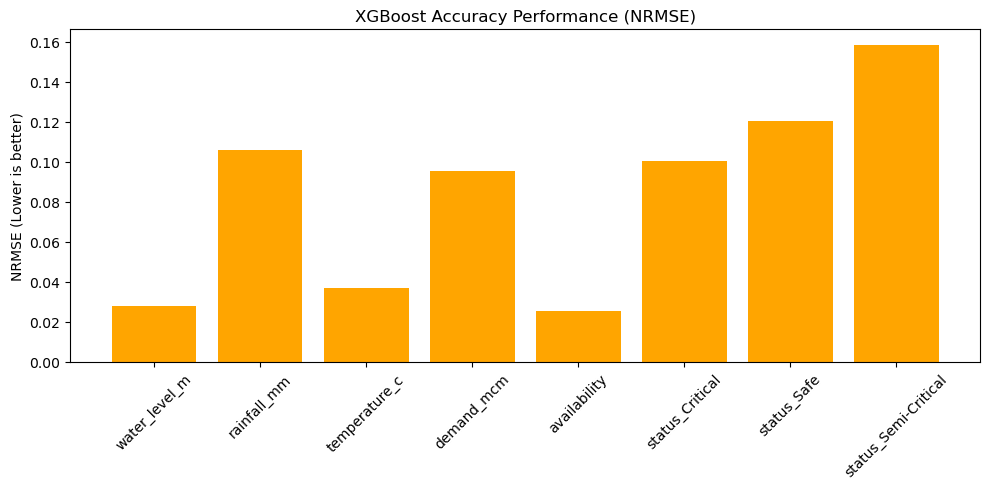


--- 24-Hour Prediction Summary (XGBoost) ---
            timestamp  water_level_m predicted_status
0 2026-01-18 01:00:00       3.923913             Safe
1 2026-01-18 02:00:00       3.923913             Safe
2 2026-01-18 03:00:00       3.894631             Safe
3 2026-01-18 04:00:00       3.892589             Safe
4 2026-01-18 05:00:00       3.928287             Safe
5 2026-01-18 06:00:00       3.929770             Safe
6 2026-01-18 07:00:00       3.872608             Safe
7 2026-01-18 08:00:00       3.887102             Safe
8 2026-01-18 09:00:00       3.903411             Safe
9 2026-01-18 10:00:00       3.911049             Safe


In [14]:
metrics_df = pd.DataFrame(metrics_summary)

plt.figure(figsize=(10, 5))
plt.bar(metrics_df['Target'], metrics_df['NRMSE'], color='orange')
plt.xticks(rotation=45)
plt.ylabel('NRMSE (Lower is better)')
plt.title('XGBoost Accuracy Performance (NRMSE)')
plt.tight_layout()
plt.show()

print("\n--- 24-Hour Prediction Summary (XGBoost) ---")
print(future_df[['timestamp', 'water_level_m', 'predicted_status']].head(10))

In [15]:
future_df.to_csv("24hrs_xgb.csv")